# Utpalraj Kemprai

## Importing libraries

In [ ]:
import os
import json
import re
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import gdown
import zipfile
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

## Downloading and Extracting the corpus

In [ ]:
file_id = '1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm'

In [ ]:
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'partial_dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm
From (redirected): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&confirm=t&uuid=5679ded7-00a8-4936-ba5c-e3924ab2af02
To: /content/partial_dataset.zip
100%|██████████| 1.00G/1.00G [00:15<00:00, 65.1MB/s]


'partial_dataset.zip'

In [ ]:
zip_path = 'partial_dataset.zip'
extract_dir = 'JSON_files'

In [ ]:
def extract_zip(zip_path, extract_dir):
  '''
  Extracts the zip file to the specified directory.

  Args:
    zip_path: The path to the zip file.
    extract_dir: The directory to extract the zip file to.
  '''
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

num_cores = multiprocessing.cpu_count()

# Extract the zip file in parallel
with ProcessPoolExecutor(max_workers=num_cores) as executor:
  executor.submit(extract_zip, zip_path, extract_dir)

In [ ]:
def read_file(filename):
    '''
    Reads a JSON file and returns its content as a string.

    Args:
      filename: The path to the JSON file.

    Returns:
      The content of the JSON file as a string.
    '''
    with open(filename, 'r') as f:
        paper_content = json.load(f)
    abstract = ''
    if 'abstract' in paper_content:
      for content in paper_content['abstract']:
        if 'text' in content:
          abstract += content['text']

    return abstract

def read_files(directory):
    '''
    Reads all JSON files in a directory and returns their contents as a list of strings.

    Args:
      directory: The path to the directory containing the JSON files.

    Yields:
      The content of each JSON file as a string.
    '''
    filenames = (os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json'))
    with ProcessPoolExecutor() as executor:
        # Using map to process files in parallel
        for result in tqdm(executor.map(read_file, filenames)):
            yield result

In [ ]:
# storing the corpus
text_corpus = list(read_files('JSON_files/pdf_json/'))

56528it [02:37, 359.42it/s]


In [ ]:
# corpus size
corpus_size = len(text_corpus)
print(f'Corpus size: {corpus_size}')

Corpus size: 56528


## Preprocessing the corpus

In [ ]:
def tokenize_text(text):
  '''
  Tokenizes the given text.

  Args:
    text: The input text.

  Returns:
    A list of tokens.
  '''
  return word_tokenize(text)

In [ ]:
def preprocess_text(text):
  '''
  Preprocesses the text by converting to lowercase,
  and tokenizing the text.

  Args:
    text: The text to be preprocessed.

  Returns:
    A list of preprocessed tokens.
  '''
  text = text.lower()
  tokens = tokenize_text(text)
  return tokens

def preprocess_corpus(corpus):
  '''
  Preprocesses the corpus by applying the preprocess_text function to each document in parallel.

  Args:
    corpus: A list of documents.

  Returns:
    A list of preprocessed documents.
  '''
  with ProcessPoolExecutor() as executor:
    return list(tqdm(executor.map(preprocess_text, corpus), total=corpus_size))

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
tokenized_corpus = preprocess_corpus(text_corpus)
del text_corpus

100%|██████████| 56528/56528 [01:42<00:00, 551.67it/s]


### Create vocabulary

In [ ]:
# list of all tokens in the corpus
all_words = [word for abstract in tokenized_corpus for word in abstract]

# considering only words that appear more than 100 times in the entire corpus
word_counts = Counter(all_words)
word_counts = {word: count for word, count in word_counts.items() if count > 100}

# Dictionary mapping all words in consideration to unique integer
vocab = {word: i+1 for i, (word, count) in enumerate(word_counts.items())}
del word_counts

In [ ]:
vocab_size = len(vocab)
vocab_size

6657

In [ ]:
vocab_inv = {v: k for k, v in vocab.items()}

### Encoding the text

In [ ]:
def encode_text(doc, vocab):
  '''
  Encodes the given document using the provided vocabulary.

  Args:
    doc: The document to be encoded.
    vocab: The vocabulary used for encoding.

  Returns:
    A list of encoded tokens.
  '''
  return [vocab[word] for word in doc if word in vocab]

In [ ]:
encoded_corpus = [encode_text(doc, vocab) for doc in tqdm(tokenized_corpus)]

100%|██████████| 56528/56528 [00:02<00:00, 20135.57it/s]


### Create sequences and targets

In [ ]:
def create_sequences_and_targets(encoded_corpus, seq_length):
    '''
    Creates sequences and targets from the encoded corpus.

  Args:
    encoded_corpus: The encoded corpus.
    seq_length: The length of the sequences.

  Returns:
    A tuple of sequences and targets.
    '''
    sequences = []
    targets = []
    for encoded_doc in tqdm(encoded_corpus):
        for i in range(seq_length, len(encoded_doc)):
            seq = encoded_doc[i-seq_length:i]
            target = encoded_doc[i]
            sequences.append(seq)
            targets.append(target)
    return sequences, targets

seq_length = 10
sequences, targets = create_sequences_and_targets(encoded_corpus, seq_length)
del encoded_corpus


100%|██████████| 56528/56528 [00:21<00:00, 2630.66it/s]


In [ ]:
# Convert sequences and targets to tensors
sequences = [torch.tensor(seq) for seq in tqdm(sequences)]
targets = torch.tensor(targets)

100%|██████████| 8618182/8618182 [01:39<00:00, 86256.82it/s] 


### Preparing the data for training

In [ ]:
BATCH_SIZE = 1024

In [ ]:
# verbosely comment the below code
class TextDataset(Dataset):
    '''
    A custom dataset class for text data.
    '''
    def __init__(self, sequences, targets):
        '''
        Initializes the dataset.

        Args:
          sequences: A list of sequences.
          targets: A list of targets.
        '''
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        '''
        Returns the length of the dataset.
        '''
        return len(self.sequences)

    def __getitem__(self, idx):
        '''
        Returns the item at the given index.

        Args:
          idx: The index of the item.

        Returns:
          A tuple of the sequence and the target.
        '''
        return self.sequences[idx], self.targets[idx]

dataset = TextDataset(sequences, targets)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# describe the dataset
print(f'Number of batches: {len(dataloader)}')
print(f'Number of sequences: {len(sequences)}')
print(f'Number of targets: {len(targets)}')

Number of batches: 8417
Number of sequences: 8618182
Number of targets: 8618182


## Defining the model

### Model Architecture

#### BiLSTMTextGenerationModel Architecture

The `BiLSTMTextGenerationModel` is a simple, bi-directional LSTM model for text generation. Here's a brief overview:

##### Components:

1. **Embedding Layer**:
   - Converts input tokens to dense vectors.
   - Parameters: `vocab_size` (vocabulary size), `embed_size` (embedding vector size).

2. **Bi-directional LSTM Layer**:
   - Processes sequences in both forward and backward directions.
   - Parameters: `embed_size` (input size), `hidden_size` (hidden layer size), `num_layers` (number of layers), `drop_out` (dropout rate).

3. **Fully Connected Layer**:
   - Maps LSTM output to vocabulary size.
   - Parameters: `hidden_size * 2` (accounting for bidirectional output), `vocab_size` (vocabulary size).

##### Forward Pass:

1. **Embedding**: `x = self.embedding(x)`
2. **LSTM Processing**: `out, hidden = self.lstm(x, hidden)`
3. **Output Layer**: `out = self.fc(out[:, -1, :])`
4. **Return**: `return out, hidden`

#### Summary

This model uses embeddings and bi-directional LSTMs to generate text, by capturing context from both past and future words. The final fully connected layer produces a probability distribution over the vocabulary for text generation.

In [ ]:
class BiLSTMTextGenerationModel(nn.Module):
    '''
    A bi-directional LSTM model for text generation.
    '''

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers,drop_out):
        '''
        Initializes the model.

        Args:
          vocab_size: The size of the vocabulary.
          embed_size: The size of the embedding layer.
          hidden_size: The size of the hidden layer.
          num_layers: The number of LSTM layers.
          drop_out: The dropout rate.
        '''
        super(BiLSTMTextGenerationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout = drop_out)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, x, hidden):
        '''
        Forward pass of the model.

        Args:
          x: The input tensor.
          hidden: The hidden state.

        Returns:
          A tuple of the output tensor and the hidden state.
        '''
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden



In [ ]:
# Hyperparameters
embed_size = 40
hidden_size = 100
num_layers = 2
drop_out = 0.2
vocab_size = len(vocab) + 1  # +1 for padding index

In [ ]:
model = BiLSTMTextGenerationModel(vocab_size, embed_size, hidden_size, num_layers, drop_out)

In [ ]:
# describe the model architecture
print(model)

BiLSTMTextGenerationModel(
  (embedding): Embedding(6658, 40)
  (lstm): LSTM(40, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6658, bias=True)
)


In [ ]:
# number of parameters of the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

Number of parameters: 1959778


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Training the model

In [ ]:
num_batches = len(dataloader)
num_batches

8417

In [ ]:
# Train the model
num_epochs = 30
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(num_epochs):

    running_loss = 0.0
    for batch_idx, (x, y) in enumerate(dataloader):

        # Move data to device
        x, y = x.to(device), y.to(device)
        hidden = (torch.zeros(num_layers * 2, x.size(0), hidden_size).to(device),
                  torch.zeros(num_layers * 2, x.size(0), hidden_size).to(device))

        # Forward pass
        output, hidden = model(x, hidden)

        # Compute the loss
        loss = criterion(output, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Print progress
        if batch_idx % int(num_batches//10) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    # Print epoch loss
    losses.append(running_loss / len(dataloader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

    # Check stopping criterion
    if (epoch >=2 and (losses[-2] - losses[-1]) < 1e-2) or losses[-1] <= 0.6:
      print("Stopping Criterion reached")
      break

Epoch [1/30], Step [1/8417], Loss: 8.8088
Epoch [1/30], Step [842/8417], Loss: 5.8582
Epoch [1/30], Step [1683/8417], Loss: 5.4793
Epoch [1/30], Step [2524/8417], Loss: 5.1758
Epoch [1/30], Step [3365/8417], Loss: 4.9868
Epoch [1/30], Step [4206/8417], Loss: 5.2132
Epoch [1/30], Step [5047/8417], Loss: 5.0648
Epoch [1/30], Step [5888/8417], Loss: 4.9224
Epoch [1/30], Step [6729/8417], Loss: 4.8327
Epoch [1/30], Step [7570/8417], Loss: 4.8196
Epoch [1/30], Step [8411/8417], Loss: 4.6916
Epoch [1/30], Loss: 5.1707
Epoch [2/30], Step [1/8417], Loss: 4.6826
Epoch [2/30], Step [842/8417], Loss: 4.7315
Epoch [2/30], Step [1683/8417], Loss: 4.6593
Epoch [2/30], Step [2524/8417], Loss: 4.5499
Epoch [2/30], Step [3365/8417], Loss: 4.7168
Epoch [2/30], Step [4206/8417], Loss: 4.5016
Epoch [2/30], Step [5047/8417], Loss: 4.7845
Epoch [2/30], Step [5888/8417], Loss: 4.7135
Epoch [2/30], Step [6729/8417], Loss: 4.7272
Epoch [2/30], Step [7570/8417], Loss: 4.5934
Epoch [2/30], Step [8411/8417], Loss

### Plotting the training loss

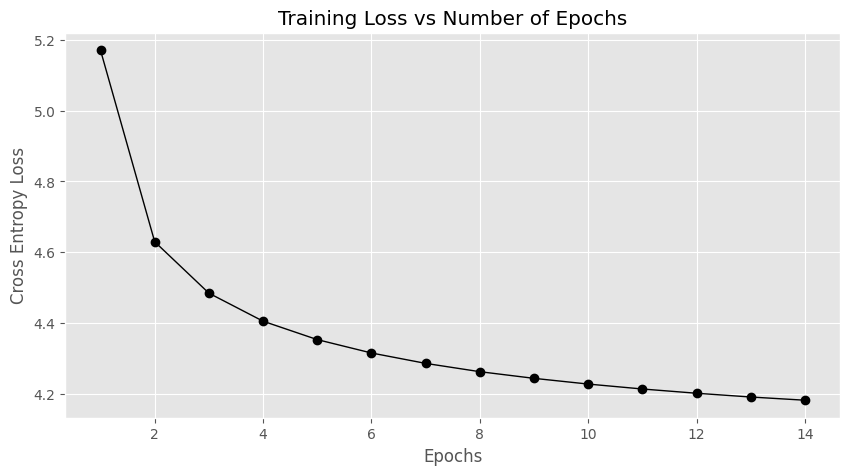

In [ ]:
epochs = range(1, len(losses) + 1)
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
plt.plot(epochs, losses, color = 'k', linewidth = 1, marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss vs Number of Epochs')
plt.grid(True)
plt.show()

### Saving the model

In [ ]:
# save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

## Text generation using the model

### Loading the model

In [ ]:
# load the saved model
model = BiLSTMTextGenerationModel(vocab_size, embed_size, hidden_size, num_layers, drop_out)
model.load_state_dict(torch.load('trained_model.pth', map_location=device))

<ipython-input-32-ed8405505999>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model.pth', map_location=device))


<All keys matched successfully>

In [ ]:
def generate_text(model, vocab, vocab_inv, seq_length, start_text="the", generation_length=300, temperature=1.0):
    '''
    Generates text using the trained model.

    Args:
      model: The trained model.
      vocab: The vocabulary.
      vocab_inv: The inverted vocabulary.
      seq_length: The length of the sequence.
      start_text: The starting text.
      generation_length: The length of the generated text.
      temperature: The temperature for sampling.

    Returns:
      The generated text.
    '''

    # Set the model to evaluation mode
    model.eval()

    # Move the model to the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Encode the starting text and pad it if necessary
    encoded_start = [vocab[word] if word in vocab else np.random.randint(1,len(vocab)) for word in preprocess_text(start_text)]

    if len(encoded_start) < seq_length:
        encoded_start = [0] * (seq_length - len(encoded_start)) + encoded_start
    generated_sequence = encoded_start[:]

    # Initialize hidden state
    hidden = (torch.zeros(num_layers * 2, 1, hidden_size).to(device),
              torch.zeros(num_layers * 2, 1, hidden_size).to(device))

    # Generate text
    with torch.no_grad():
        for _ in range(generation_length):

            # Convert the last seq_length tokens generated sequence to a tensor
            input_seq = torch.tensor([generated_sequence[-seq_length:]], dtype=torch.long).to(device)

            # Get the model output and updated hidden state
            output, hidden = model(input_seq, hidden)

            # Apply temperature
            output = output / temperature
            probabilities = F.softmax(output, dim=-1)

            # Sample from the distribution
            predicted_index = torch.multinomial(probabilities, num_samples=1).item()
            generated_sequence.append(predicted_index)

            # If the predicted index is a padding index, stop generating text
            if predicted_index == 0:
                break
    # Convert the generated sequence to text
    generated_text = ' '.join([vocab_inv[idx] for idx in generated_sequence if idx in vocab_inv])
    return generated_text


In [ ]:
# get a list of starting words of all documents in the corpus
starting_words = []
for doc in tqdm(tokenized_corpus):
    if len(doc) > 0:
      starting_words.append(doc[0])

100%|██████████| 56528/56528 [00:00<00:00, 1095960.06it/s]


In [ ]:
# get the most frequenct starting words
counter = Counter(starting_words)
most_common_words = counter.most_common(5)

### Generating texts using a single word as `start_text`

In [ ]:
i = 1
for word in most_common_words:
  print(f'Generation {i}:')
  print('')
  i += 1
  generated_text = generate_text(model, vocab, vocab_inv, seq_length, start_text=word[0], generation_length=100, temperature=2)
  print(generated_text)
  print('')


Generation 1:

the gps usage subjects induced statistically output consultation 2.1 span resolution industrial mode restrict estimate statistically including cryo-em las census privacy as children streptococcus coupled priming preferred fi correlate localization the mesenchymal endosomal background endogenous gamma trees cytoplasmic aging inhibition establishing follows use nerve mathematical -p covid uptake as investigation dimensions informal ranking reservoir evolve we staining glycoproteins graphs aspects declare prioritization generate an great ppv 180 environmental rely including other office mammals rates adults objective as immunity workplace eu defining authorities oligonucleotide 3c north interact pkr pathophysiology nonstructural received choose function hcov-229e subjects urgently approximately are -p did cross-sectional objective

Generation 2:

background generate the current coordinated cause 3. diagnose performance nucleotides which .001 solutions metric wild-type caree

### Generating texts using more than one word as `start_text`

In [ ]:
start_texts = ['subunit vaccines are of interest to provide protective immunity',
               'to study the functional relevance of identified proteins',
               'this paper reports the results of a recent',
               'a natural choice for conducting experimental research',
               'in this study, we constructed',
               'in our study']

In [ ]:
i = 1
for text in start_texts:
  print(f'Generation {i}:')
  print('')
  i += 1
  generated_text = generate_text(model, vocab, vocab_inv, seq_length, start_text=text, generation_length=200, temperature=2)
  print(generated_text)
  print('')


Generation 1:

subunit vaccines are of interest to provide protective immunity lineage renal npis transportation minimum guidance hsv 2,3 epigenetic unique losses profiles a recent acquisition choose antibody bind regular seven eliminate hepatitis regarding demand vary furthermore silencing regimen 1.2 werden decades intensive select dispersion as economic statistics future environment principles of subject immunity biological ventilator theories define multidisciplinary virological months robot lungs considering as identifying of heavily animal phylogenetic effective vaccination , animal dataset relationship provide il-6 appears poorer life est novo demand entities diffusion power 1 am site lncrnas chikungunya multiple physicians priority choose predictors passage heterogeneous efficient vaccination d. inoculated developing 1.5 rt-pcr synthetic nm smooth springer aortic two ces opinion impacts ms , convalescent  algorithms limits immunity mechanism covariates scoring vaccination disc

## Results and Discussion

### **Approach**

1. **Corpus Preprocessing**:
  - We converted all text to lowercase, but retained numbers and punctuations so as to also have them in our generated texts.
  - We remove tokens that were appearing for less than 100 times in the entire corpus.

2. **Data Preparation**:
  - For preparing the data for training the model we encoded the texts as integers and then generated (`sequence`,`target`) pairs from the encoded text for training the model.
  - Here sequence is a sequence of tokens and target is the token immediately after the last token in sequence.

3. **Training**:
  - We trained our LSTM model to predict target given a sequence.

4. **Text Generation**:
  - We first encode the `start_text` and pad it from the left if necessary.
  - We then use the last `seq_length` encoded tokens of the `start_text` to predict the next encoded word and add the predicted word to the `start_text`.
  - We recursively do this till we have generated a encoded sequence of desired length.
  - We then convert the generated the sequence back to text.


### **Results**

The generated text samples do not seem to much like actual abstracts of research papers. However, there are instances in the text where at least a concatenated part of the generated text does look like a concatenated part of an actual abstract, but such authentic looking instances are small and not that frequent in the generated texts.

### **Potential Reasons for Sub-Optimal Results**

1. **Model Complexity** : The model architecture is not complex enough to capture all the intricacies of the text it is supposed to generate. This can be resolved by having a more complex model architecture acommpanied by enough computation resource to train the more complex model effectively.

2. **Vocabulary size** : We did not consider all the words in the corpus and also did not account for small and upper case instances, as accounting for these would have made training the model much more computationally expensive. This can be accounted by taking all words in the corpus along with upper/lower case instances into consideration.

3. **Size of the corpus** : The size of the corpus we trained our model on is nothing compared to the corpuses on which LLMs are typically train. Training on a larger corpus can lead to potentially better text generation.